<a href="https://colab.research.google.com/github/JeoungHojin/image_process/blob/main/geo_trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target Image: /content/drive/MyDrive/1611a.jpg

>>> 1. 회전 변환 실행 중...


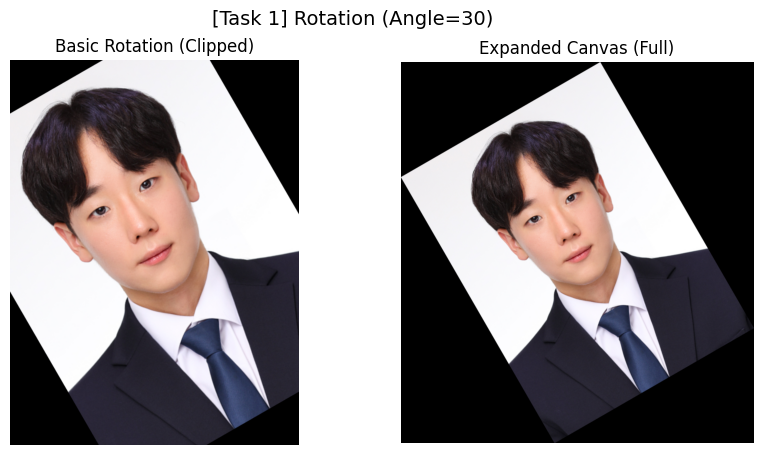


>>> 2. 크기 변환(확대) 실행 중...


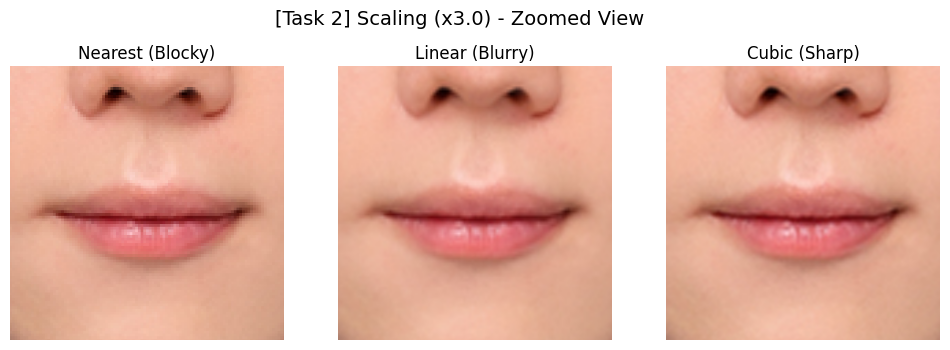


>>> 3. 원근 변환 실행 중...


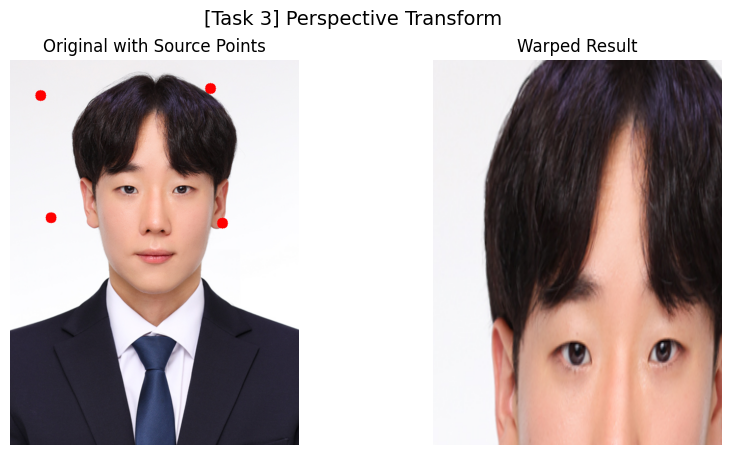

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 공통 설정: 이미지 경로
# ---------------------------------------------------------
img_path = '/content/drive/MyDrive/1611a.jpg'

def check_image():
    """이미지가 정상적으로 로드되는지 확인"""
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: 이미지를 찾을 수 없습니다. 경로를 확인해주세요: {img_path}")
        return None
    return img

# =========================================================
# 1. 회전 변환 (기본 회전 vs 잘림 방지 회전)
# =========================================================
def run_rotation():
    img = check_image()
    if img is None: return

    # BGR -> RGB (Matplotlib용)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # (1) 기본 회전 (잘림 발생)
    center = (w / 2, h / 2)
    angle = 30
    scale = 1.0
    M1 = cv2.getRotationMatrix2D(center, angle, scale)
    rot_basic = cv2.warpAffine(img_rgb, M1, (w, h))

    # (2) 캔버스 확장 회전 (잘림 방지)
    # 회전 후의 새로운 너비(new_w)와 높이(new_h) 계산
    rad = np.radians(angle)
    sin = np.sin(rad)
    cos = np.cos(rad)

    new_w = int((h * abs(sin)) + (w * abs(cos)))
    new_h = int((h * abs(cos)) + (w * abs(sin)))

    # 중심점 보정 (Translation)
    M2 = M1.copy()
    M2[0, 2] += (new_w / 2) - center[0]
    M2[1, 2] += (new_h / 2) - center[1]

    rot_full = cv2.warpAffine(img_rgb, M2, (new_w, new_h))

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"[Task 1] Rotation (Angle={angle})", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.title("Basic Rotation (Clipped)")
    plt.imshow(rot_basic)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Expanded Canvas (Full)")
    plt.imshow(rot_full)
    plt.axis('off')

    plt.show()

# =========================================================
# 2. 크기 변환 (보간법 별 화질 비교)
# =========================================================
def run_scaling():
    img = check_image()
    if img is None: return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 3배 확대
    scale_factor = 3.0

    # 보간법 적용
    up_nearest = cv2.resize(img_rgb, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
    up_linear = cv2.resize(img_rgb, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
    up_cubic = cv2.resize(img_rgb, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    # 시각화 (확대된 부분 크롭해서 보여주기)
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"[Task 2] Scaling (x{scale_factor}) - Zoomed View", fontsize=14)

    images = [up_nearest, up_linear, up_cubic]
    titles = ['Nearest (Blocky)', 'Linear (Blurry)', 'Cubic (Sharp)']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])

        # 중앙 부분 크롭하여 디테일 확인
        h, w, _ = images[i].shape
        cy, cx = h // 2, w // 2
        crop_size = 150 # 크롭 영역 크기

        # 이미지 범위 벗어나지 않게 처리
        y1 = max(0, cy - crop_size)
        y2 = min(h, cy + crop_size)
        x1 = max(0, cx - crop_size)
        x2 = min(w, cx + crop_size)

        plt.imshow(images[i][y1:y2, x1:x2])
        plt.axis('off')

    plt.show()

# =========================================================
# 3. 원근 변환 (Perspective Transform)
# =========================================================
def run_perspective():
    img = check_image()
    if img is None: return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # [주의] src_points는 1611a.jpg 이미지 내의 '펴고 싶은 사각형의 네 모서리' 좌표여야 합니다.
    # 만약 결과가 이상하면 아래 좌표를 해당 이미지에 맞게 수정해야 합니다.
    # (좌상, 우상, 좌하, 우하 순서)
    src_points = np.float32([
        [56, 65],   # 좌상
        [368, 52],  # 우상
        [75, 290],  # 좌하
        [390, 300]  # 우하
    ])

    # 출력될 이미지 크기 (300 x 400)
    width, height = 300, 400
    dst_points = np.float32([
        [0, 0],
        [width, 0],
        [0, height],
        [width, height]
    ])

    # 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(img_rgb, M, (width, height))

    # 시각화 (원본에 선택된 점 표시)
    img_display = img_rgb.copy()
    for pt in src_points:
        cv2.circle(img_display, (int(pt[0]), int(pt[1])), 10, (255, 0, 0), -1)

    plt.figure(figsize=(10, 5))
    plt.suptitle("[Task 3] Perspective Transform", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.title("Original with Source Points")
    plt.imshow(img_display)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Warped Result")
    plt.imshow(warped)
    plt.axis('off')

    plt.show()

# ---------------------------------------------------------
# 실행 (원하는 실습만 주석 해제하여 실행 가능)
# ---------------------------------------------------------
if __name__ == "__main__":
    print(f"Target Image: {img_path}")

    print("\n>>> 1. 회전 변환 실행 중...")
    run_rotation()

    print("\n>>> 2. 크기 변환(확대) 실행 중...")
    run_scaling()

    print("\n>>> 3. 원근 변환 실행 중...")
    run_perspective()